In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [15]:
global slack_parser
# combine all json file in all-weeks8-9
def slack_parser(path_channel):
    """ parse slack data to extract useful informations from the json file
        step of execution
        1. Import the required modules
        2. read all json file from the provided path
        3. combine all json files in the provided path
        4. extract all required informations from the slack data
        5. convert to dataframe and merge all
        6. reset the index and return dataframe
    """

    # specify path to get json files
    combined = []
    
    print(path_channel)
    json_files = glob.glob(f"{path_channel}*.json")
    print(json_files)
    for json_file in glob.glob(f"{path_channel}*.json"):
        with open(json_file, 'r', encoding="utf8") as slack_data:
            data=json.load(slack_data)
            combined.append(data)

    # loop through all json files and extract required informations
    dflist = []
    for slack_data in combined:

        msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st, reply_users, \
        reply_count, reply_users_count, tm_thread_end = [],[],[],[],[],[],[],[],[],[]

        for row in slack_data:
            if 'bot_id' in row.keys():
                continue
            else:
                msg_type.append(row['type'])
                msg_content.append(row['text'])
                if 'user_profile' in row.keys(): sender_id.append(row['user_profile']['real_name'])
                else: sender_id.append('Not provided')
                time_msg.append(row['ts'])
                if 'blocks' in row.keys() and row['blocks'] is not None and len(row['blocks'][0]['elements'][0]['elements']) != 0 :
                     msg_dist.append(row['blocks'][0]['elements'][0]['elements'][0]['type'])
                else: msg_dist.append('reshared')
                if 'thread_ts' in row.keys():
                    time_thread_st.append(row['thread_ts'])
                else:
                    time_thread_st.append(0)
                if 'reply_users' in row.keys(): reply_users.append(",".join(row['reply_users'])) 
                else:    reply_users.append(0)
                if 'reply_count' in row.keys():
                    reply_count.append(row['reply_count'])
                    reply_users_count.append(row['reply_users_count'])
                    tm_thread_end.append(row['latest_reply'])
                else:
                    reply_count.append(0)
                    reply_users_count.append(0)
                    tm_thread_end.append(0)
        data = zip(msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st,
         reply_count, reply_users_count, reply_users, tm_thread_end)
        columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type',
         'time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end']

        df = pd.DataFrame(data=data, columns=columns)
        df = df[df['sender_name'] != 'Not provided']
        dflist.append(df)

    dfall = pd.concat(dflist, ignore_index=True)
    dfall['channel'] = path_channel.split('/')[-1].split('.')[0]        
    dfall = dfall.reset_index(drop=True)
    
    return dfall

# Use the path to the JSON file in your code
global slack_data 
slack_data= slack_parser('../data/all-week8/')

def parse_slack_reaction(path, channel):
    """get reactions"""
    dfall_reaction = pd.DataFrame()
    combined = []
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)

    reaction_name, reaction_count, reaction_users, msg, user_id = [], [], [], [], []

    for k in combined:
        slack_data = json.load(open(k.name, 'r', encoding="utf-8"))
        
        for i_count, i in enumerate(slack_data):
            if 'reactions' in i.keys():
                for j in range(len(i['reactions'])):
                    msg.append(i['text'])
                    user_id.append(i['user'])
                    reaction_name.append(i['reactions'][j]['name'])
                    reaction_count.append(i['reactions'][j]['count'])
                    reaction_users.append(",".join(i['reactions'][j]['users']))
                
    data_reaction = zip(reaction_name, reaction_count, reaction_users, msg, user_id)
    columns_reaction = ['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id']
    df_reaction = pd.DataFrame(data=data_reaction, columns=columns_reaction)
    print(df_reaction)
    df_reaction['channel'] = channel
    return df_reaction

# Use the path to the JSON file in your code
slack_reactions = parse_slack_reaction('../data/all-week8/','10 Acadamy Commnunity')
# print(slack_reactions)
def get_community_participation(path):
    """ specify path to get json files"""
    combined = []
    comm_dict = {}
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)
    # print(f"Total json files is {len(combined)}")
    for i in combined:
        a = json.load(open(i.name, 'r', encoding='utf-8'))

        for msg in a:
            if 'replies' in msg.keys():
                for i in msg['replies']:
                    comm_dict[i['user']] = comm_dict.get(i['user'], 0)+1
    return comm_dict


print("----particiapations--------")
# Use the path to the JSON file in your code
slack_get_community_participation = get_community_participation('../data/all-week8/')
print(slack_get_community_participation)

../data/all-week8/
['../data/all-week8\\2022-10-09.json', '../data/all-week8\\2022-10-10.json', '../data/all-week8\\2022-10-11.json', '../data/all-week8\\2022-10-12.json', '../data/all-week8\\2022-10-13.json', '../data/all-week8\\2022-10-14.json', '../data/all-week8\\2022-10-15.json']
                reaction_name  reaction_count  \
0                raised_hands              10   
1                        clap               1   
2   raised_hands::skin-tone-3               1   
3                     flushed               6   
4                        eyes               2   
5                       smile               4   
6                         joy               1   
7                          +1               2   
8            white_check_mark               1   
9            white_check_mark               1   
10           white_check_mark               1   
11           white_check_mark               1   
12           white_check_mark               3   
13           white_check_mar

In [16]:
def convert_2_timestamp(column, data):
    """convert from unix time to readable timestamp
        args: column: columns that needs to be converted to timestamp
                data: data that has the specified column
    """
    
    if column in data.columns.values:
        timestamp_ = []
        for time_unix in data[column]:
            if time_unix == 0:
                timestamp_.append(0)
            else:
                a = datetime.datetime.fromtimestamp(float(time_unix))
                timestamp_.append(a.strftime('%Y-%m-%d %H:%M:%S'))
        return timestamp_
    else: 
        print(f"{column} not in data")
        
convert_2_timestamp('msg_sent_time',slack_data)   
print(convert_2_timestamp)

def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))

slack_get_tagged_users=get_tagged_users(slack_data)
#print(slack_get_tagged_users)

 

def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

<function convert_2_timestamp at 0x000001A5E5ABFD80>


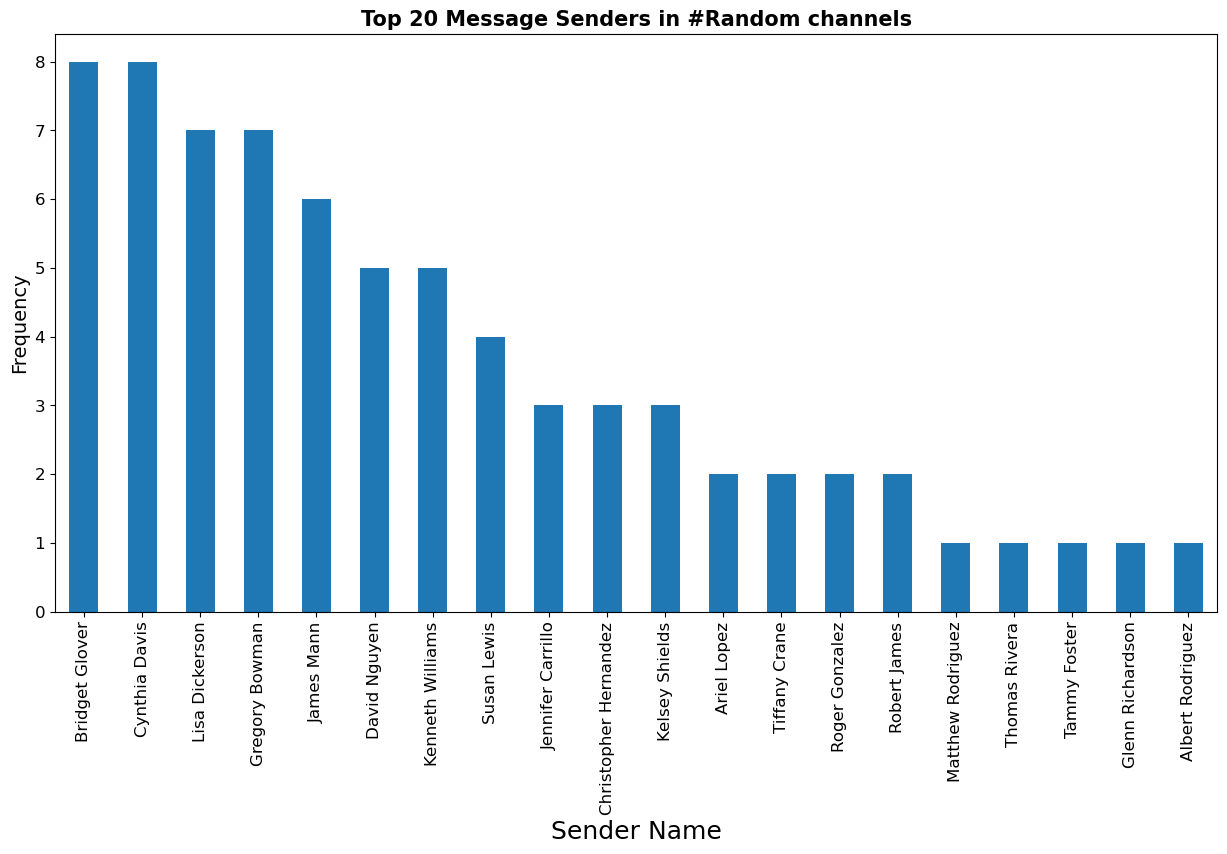

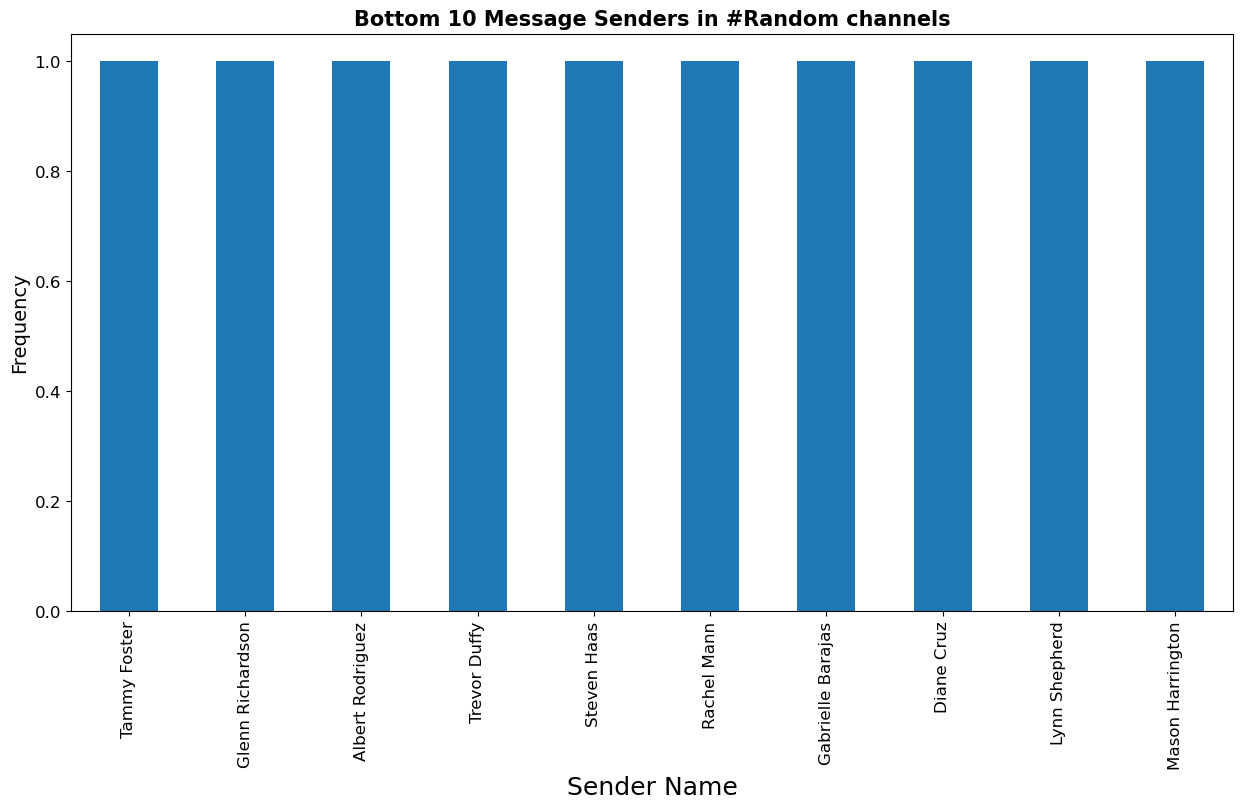

In [17]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()
 
get_top_20_user(slack_data)  

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

   
def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()
    

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

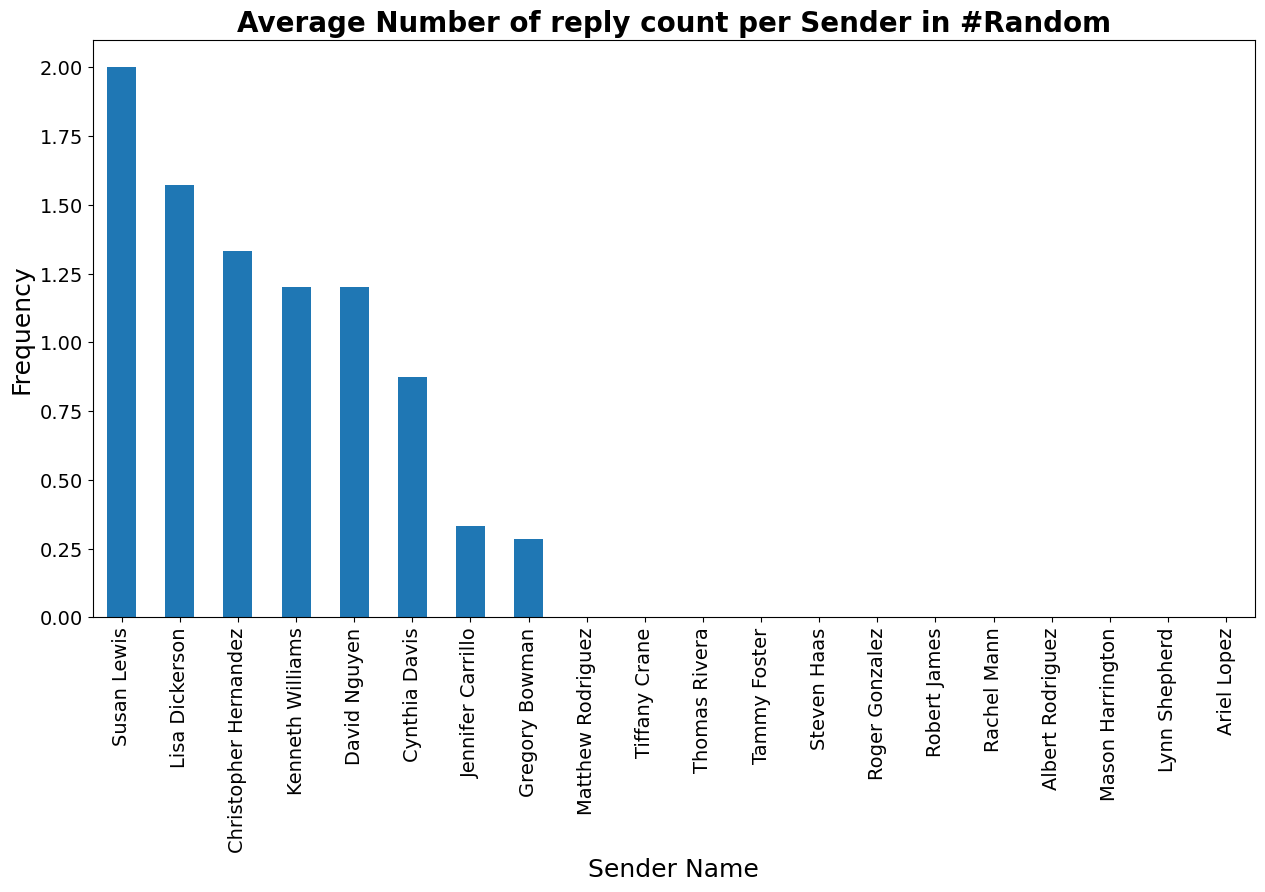

In [18]:
# Visualize reply counts per user per channel
  
draw_avg_reply_count(slack_data)   


In [19]:
# what is the time range of the day that most messages are sent?

def get_time_range_with_most_messages(data):
    # Extract the hour component from the timestamps
    print(data['msg_sent_time'])
    data['time'] = convert_2_timestamp('msg_sent_time',slack_data)
    print(data['time'])
    # Calculate message count for each hour
    message_count_by_time = data['time'].value_counts().sort_index()

    # Find the time with the highest message count
    time_with_most_messages = message_count_by_time.idxmax()

    # Calculate the time range based on the time with the highest message count
    time_range = pd.to_datetime(time_with_most_messages).strftime('%I:%M %p')

    return time_range

# Call the function to get the time range with the most messages
most_active_time_range = get_time_range_with_most_messages(slack_data)

# Print the result
print("The time range of the day with the most messages is:", most_active_time_range)

0     1665385707.569729
1     1665385734.616309
2     1665385760.620169
3     1665387214.795849
4     1665388127.826899
            ...        
74    1665744861.425069
75    1665756107.060959
76    1665756126.005109
77    1665756165.638109
78    1665837934.076499
Name: msg_sent_time, Length: 79, dtype: object
0     2022-10-10 10:08:27
1     2022-10-10 10:08:54
2     2022-10-10 10:09:20
3     2022-10-10 10:33:34
4     2022-10-10 10:48:47
             ...         
74    2022-10-14 13:54:21
75    2022-10-14 17:01:47
76    2022-10-14 17:02:06
77    2022-10-14 17:02:45
78    2022-10-15 15:45:34
Name: time, Length: 79, dtype: object
The time range of the day with the most messages is: 10:08 AM


In [20]:
# what kind of messages are replied faster than others?
print(slack_data.columns.values)

import pandas as pd

def message_replied_faster(messages, num_messages=5):
    """Identify messages that received faster replies based on response times"""

    # Convert the 'msg_sent_time' column to datetime type
    messages['sent_time'] = convert_2_timestamp('msg_sent_time',slack_data)

    # Sort the messages DataFrame by 'msg_sent_time' in ascending order
    messages = messages.sort_values('sent_time')

    # Calculate the time difference between consecutive messages
    messages['response_time'] = messages['msg_sent_time']

    # Filter out the first message (since it doesn't have a previous message for comparison)
    messages = messages[1:]

    # Find the messages with the fastest response time
    fastest_replies = messages.nsmallest(num_messages, 'response_time')

    return fastest_replies[['msg_content', 'response_time']]

# Example usage:
# Assuming you have a DataFrame 'messages' with the specified column structure
fastest_replies = message_replied_faster(slack_data, num_messages=5)
print(fastest_replies) 

['msg_type' 'msg_content' 'sender_name' 'msg_sent_time' 'msg_dist_type'
 'time_thread_start' 'reply_count' 'reply_users_count' 'reply_users'
 'tm_thread_end' 'channel' 'time']


TypeError: Column 'response_time' has dtype object, cannot use method 'nsmallest' with this dtype

In [21]:
# Relationship between # of messages and # of reactions

In [22]:
# Which users got the most reactions?
def get_users_with_most_reactions(messages, num_users=5):
    """Get the users with the most reactions in the messages"""

    # Group the messages by sender_name and calculate the sum of reactions
    user_reactions = messages.groupby('sender_name')['reply_users_count'].sum()

    # Sort the user_reactions Series in descending order
    user_reactions = user_reactions.sort_values(ascending=False)

    # Get the top users with the most reactions
    top_users = user_reactions.head(num_users)

    return top_users

# Example usage:
# Assuming you have a DataFrame 'messages' with columns 'sender_name' and 'reply_users_count'
top_users_with_reactions = get_users_with_most_reactions(slack_data, num_users=5)
print(top_users_with_reactions)

sender_name
Lisa Dickerson           8
Kenneth Williams         6
Susan Lewis              5
Christopher Hernandez    4
Cynthia Davis            4
Name: reply_users_count, dtype: int64


In [23]:
#What is the distribution of time differences between messages,replies, reactions, and any type event (message, reply, reaction)?

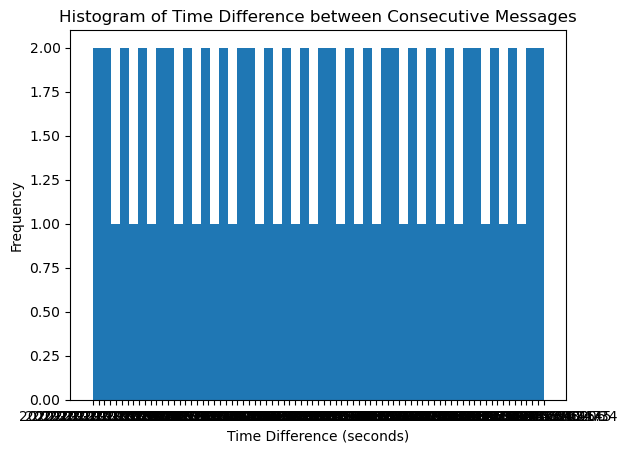

In [28]:
#Plot a histogram of the time difference between Consecutive messages
 
def plot_message_time_histogram(messages):
    """Plot a histogram of the time difference between consecutive messages"""

    # Convert the timestamp column to DateTime type
    messages['timestamp'] = convert_2_timestamp('msg_sent_time',slack_data)
    

    # Calculate the time difference between consecutive messages
    time_diff = messages['timestamp']

    # Plot the histogram
    plt.hist(time_diff, bins=50)
    plt.xlabel('Time Difference (seconds)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Time Difference between Consecutive Messages')
    plt.show()


plot_message_time_histogram(slack_data)

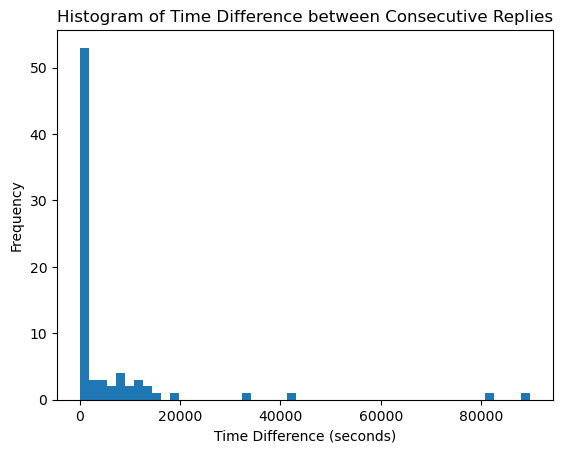

In [29]:
#Plot a histogram of the time difference between Consecutive replies
import pandas as pd
import matplotlib.pyplot as plt

def plot_reply_time_histogram(replies):
    """Plot a histogram of the time difference between consecutive replies"""

    # Convert the timestamp column to DateTime type
    replies['timestamp'] = pd.to_datetime(replies['timestamp'])

    # Sort the replies by timestamp
    replies = replies.sort_values('timestamp')

    # Calculate the time difference between consecutive replies
    time_diff = replies['timestamp'].diff().dropna()

    # Plot the histogram
    plt.hist(time_diff.dt.total_seconds(), bins=50)
    plt.xlabel('Time Difference (seconds)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Time Difference between Consecutive Replies')
    plt.show()

replies=slack_data
 
plot_reply_time_histogram(replies)

In [ ]:
#Plot a histogram of the time difference between Consecutive reactions


In [33]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

In [107]:
# Which channel has the highest activity?

def get_channel_with_highest_activity(messages):
    """Get the channel with the highest activity based on the total number of messages"""

    # Group the messages by channel and count the number of messages in each channel
    channel_activity = messages.groupby('channel')['sender_name'].count()

    # Find the channel with the highest activity
    channel_with_highest_activity = channel_activity.idxmax()

    return channel_with_highest_activity

# Example usage:
# Assuming you have a DataFrame 'messages' with a column 'channel' representing the channel name
channel_with_highest_activity = get_channel_with_highest_activity(slack_data)
print(channel_with_highest_activity)

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?